# Note
Hi Reviewer,

Thanks for your time to review my capestone project. I want to make some note at top to save your time on review my project.

- structure
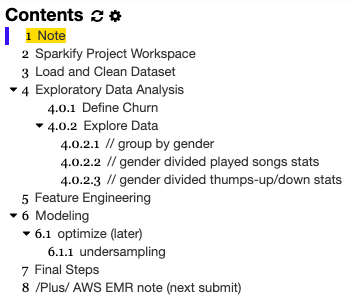

- request for coaching
    - **Q1:How to practice Sprak at real world?** I am new to spark, I manage about 3 week to finish this project, and still get some unclear on part of it. So where can I get some real big data to explore the skill of spark (on AWS, not local). Can you share something?
    - **Q2:Spark vs Flink** I do some research that both Spark and Flink are super-stars nowadays. While Spark come from batch to stream, and Flink come from stream to batch. How shoud I choose from them. Or for the short, what are the pro and cons for Spark and Flink on differed situation?
    
- notice
    - data file: for the git limit < 100MB, I use a compressed file to complete(also the same with 128MB at local, if you want to r

- version 
    - version1 - 
    - version2 - finish uda workplace run out.
    - version3 - finish local run out. (mac env)
    - version4 - (finished at next submit) - aws emr run out, and take a new chaper at the end `/Plus/ AWS EMR note`
    
Thanks a lot again, waiting for you reply.
Meng

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# spark env check（mac）
# java check
!java -version
# 如果不是 1.8 需要
## 关掉jupyter notebook，之后在terminal运行
## export JAVA_HOME=`/usr/libexec/java_home -v 1.8.0_212`
## 如果版本号不对（小版本可能会升级）需要查询 /usr/libexec/java_home -V
## 完成后再次检查版本，输出为类似 java version "1.8.0_212"

# pyspark check
## pyspark 有时需要调整小版本比如从 2.44 - 2.32
## 直接 conda install 就可以变更
## conda install pyspark=2.3

java version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import re

In [3]:
# create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sparky').getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#(DO NOT RUN)
# load 10% smaller file in pandas 
## load data
'''
import pandas as pd
file = 'mini_sparkify_event_data.json.bz2'
#file='10pre_mini_sparkify_event_data.json.bz2'
## 验证可以使用10pre更小的数据集
df = pd.read_json(file,'sparkify_donate',compression='bz2')
display(df.size)
display(df.head(1))

# 关于效率的记录
## 10%mini bz2 read time 3.07s 660ms(2nd)
## mini bz2 read time 5.53s 5.51s(2nd)
## 两个时间对比2nd，大概是10倍的差别
## 4*3.6gb cpu使用了20%
## 之前很慢和java环境有关（Mac待测试，不过CPU相差较多）
## 记得最近java8升级了2次，和之前的小版本有所区别

## 另外，使用 bz2 （gz也行但压缩率没有bz2高） 
## 这两种格式是 splittble 的，可以使用所有 spark 节点读取
#df = spark.read.json('mini_sparkify_event_data.json')
## 不设定名字貌似最后一步会报错,和ibm有关，drop，研究a'w's
'''

'''
java version "1.8.0_231"
Java(TM) SE Runtime Environment (build 1.8.0_231-b11)
Java HotSpot(TM) Client VM (build 25.231-b11, mixed mode, sharing)
''';

# get smaller data
'''
## smaller
pddf_small = pddf.sample(frac=0.1)
display(pddf_small.size)
display(pddf_small.head(1))

## new file name
newfile = '10pre_' + file
print(newfile)

## persistence compression
pddf_small.to_json(newfile,compression='bz2')

## persistence normal
pddf_small.to_json('10pre_mini_sparkify_event_data.json')
''';

In [5]:
# read df to spark
## beware of to choose approate file
#file_ori = 'mini_sparkify_event_data.json'
file_ori = 'mini_sparkify_event_data.json.bz2'
df = spark.read.json(file_ori)
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
# clean df
## na/dup
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
## NaN user
df_clean = df_clean.filter(df["userId"] != "")
## count
df_clean.count()

278154

In [7]:
# df check sample
print('--- persisit ---')
display(df_clean.persist)
print('--- userId ---')
display(df_clean.select("userId").sort("userId").show())
print('--- sessionId ---')
display(df_clean.select("sessionId").sort("userId").show())

--- persisit ---


<bound method DataFrame.persist of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

--- userId ---
+------+
|userId|
+------+
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
|    10|
+------+
only showing top 20 rows



None

--- sessionId ---
+---------+
|sessionId|
+---------+
|     1592|
|      595|
|      595|
|      595|
|      595|
|      595|
|     1414|
|      595|
|     1592|
|      595|
|      595|
|     1981|
|     1592|
|      595|
|        9|
|      595|
|      595|
|      595|
|      595|
|     1981|
+---------+
only showing top 20 rows



None

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
# check - 'page' value
df_clean.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [9]:
# filter cancel user

## 使用 Cancellation Confirmation 来定义客户流失
cancel_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cancel_user_list = [user["userId"] for user in cancel_user_df.collect()]
display(cancel_user_list[:10])

## create column for canceled or not user on category type
df_clean = df_clean.withColumn("cancel", df_clean.userId.isin(cancel_user_list))
df_clean

['125', '51', '54', '100014', '101', '29', '100021', '87', '73', '3']

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, cancel: boolean]

#### // group by gender

In [10]:
# group by gender
df_clean.dropDuplicates(['userId']).groupby(['gender','cancel']).count().show()

+------+------+-----+
|gender|cancel|count|
+------+------+-----+
|     M|  true|   32|
|     F| false|   84|
|     F|  true|   20|
|     M| false|   89|
+------+------+-----+



#### // gender divided played songs stats

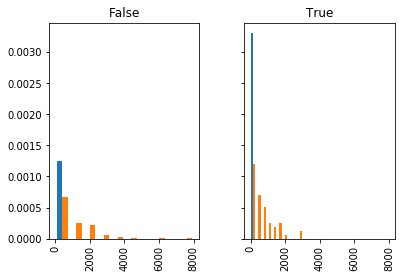

In [11]:
# gender divided played songs stats
df_clean_songs = df_clean.where(df_clean.song!='null').groupby(['cancel','userId']) \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('cancel').toPandas()
df_clean_songs.hist(['SongsPlayed'], by='cancel', sharex=True, sharey=True,density=1)
plt.plot();

#### // gender divided thumps-up/down stats

ThumbsUps for people who stay 62.89411764705882
ThumbsUps for people who leave 37.18


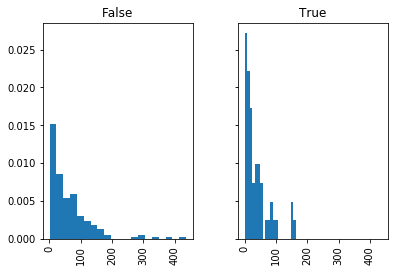

In [12]:
# gender divided thumps-up/down stats (up)
df_clean_thumbsup = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('cancel').toPandas()
df_clean_thumbsup.hist('ThumbsUps', by='cancel', bins=20, sharex=True, sharey=True, density=1);

print('ThumbsUps for people who stay',
      df_clean_thumbsup[df_clean_thumbsup['cancel']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',
      df_clean_thumbsup[df_clean_thumbsup['cancel']==True]['ThumbsUps'].mean())

ThumbsDowns for people who stay 12.735294117647058
ThumbsDowns for people who leave 11.545454545454545


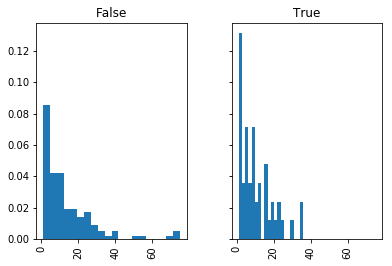

In [13]:
# git rid of warnings
import warnings; warnings.simplefilter('ignore')

# gender divided thumps-up/down stats (down)
df_clean_thumbsdown = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('cancel').toPandas()
df_clean_thumbsdown.hist('ThumbsDowns', by='cancel', bins=20, sharex=True, sharey=True, density=1);

print('ThumbsDowns for people who stay',
      df_clean_thumbsdown[df_clean_thumbsup['cancel']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',
      df_clean_thumbsdown[df_clean_thumbsup['cancel']==True]['ThumbsDowns'].mean())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
# feature1 gender
df_gender = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast("int"))

df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [15]:
# feature2 played songs
df_songs = df_clean.where(df_clean.song!='null').groupby('userId') \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [16]:
# feature3 thumps up/down
df_thumbsup = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])
df_thumbsdown = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])
df_thumbsup.show(),df_thumbsdown.show();

+------+---------+
|userId|ThumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
|100009|       23|
|100010|       17|
|100012|       18|
|100013|       39|
|100014|       17|
|100015|       35|
|100016|       25|
|100017|        2|
|100018|       46|
|100019|        1|
+------+---------+
only showing top 20 rows

+------+-----------+
|userId|ThumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
|100011|          1|
|100012|          9|
|100013|         15|
|100014|          3|
|100015|          8|
|100016|          5|
|100017|          1|
|100018|          9|
|100019|          1|
|100021|          5|
+------+-----------+
only showing t

In [17]:
# feature4 singers number
df_singers = df_clean.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_clean.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])
df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+------+---------------+
only showing top 20 rows



In [18]:
# join features
df_final = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','cancel'])
for feature in [df_gender, df_songs,df_thumbsup,df_thumbsdown,df_singers]:
    df_final = df_final.join(feature,'userId')
    
df_final.show()

+------+------+------+-----------+---------+-----------+---------------+
|userId|cancel|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+------+------+-----------+---------+-----------+---------------+
|    10| false|     0|        673|       37|          4|            565|
|   100| false|     0|       2682|      148|         27|           1705|
|100001|  true|     1|        133|        8|          2|            125|
|100004| false|     1|        942|       35|         11|            733|
|100005|  true|     0|        154|        7|          3|            149|
|100006|  true|     1|         26|        2|          2|             26|
|100007|  true|     1|        423|       19|          6|            357|
|100008| false|     1|        772|       37|          6|            623|
|100009|  true|     0|        518|       23|          8|            442|
|100010| false|     1|        275|       17|          5|            252|
|100012|  true|     0|        476|       18|       

In [19]:
df_final.dtypes

[('userId', 'string'),
 ('cancel', 'boolean'),
 ('gender', 'string'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('SingersListened', 'bigint')]

In [20]:
# file persistence
## saving to csv
file_final = 'mini_sparkify_event_data_final_3.json'
df_final.write.save(file_final, format="json")

## read final data (much quick for show)
df_final = spark.read.json(file_final)
df_final.show()

+---------------+-----------+-----------+---------+------+------+------+
|SingersListened|SongsPlayed|ThumbsDowns|ThumbsUps|cancel|gender|userId|
+---------------+-----------+-----------+---------+------+------+------+
|           1159|       1669|         52|       68| false|     1|200008|
|            746|        963|         32|       41| false|     0|200009|
|           1025|       1427|         15|      132| false|     1|300009|
|            244|        263|          1|       21| false|     0|300010|
|           1170|       1640|         24|      132| false|     0|300018|
|            650|        798|          8|       83| false|     0|300019|
|           1018|       1417|         17|       62| false|     0|    30|
|           1201|       1749|         17|      148|  true|     1|300001|
|            317|        367|         11|       13|  true|     0|200018|
|            427|        495|         17|       28| false|     0|200019|
|           1221|       1779|         15|       93|

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [21]:
# check
df_final.dtypes

[('SingersListened', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('cancel', 'boolean'),
 ('gender', 'string'),
 ('userId', 'string')]

In [22]:
# convert data type of columns into float
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))
    
df_final.dtypes

[('SingersListened', 'bigint'),
 ('SongsPlayed', 'float'),
 ('ThumbsDowns', 'float'),
 ('ThumbsUps', 'float'),
 ('cancel', 'float'),
 ('gender', 'float'),
 ('userId', 'float')]

In [23]:
# !!! lazy !!!
## 特别慢！这里 show|head、 在mac 和windows很慢,原因是 spark 的 lazy 机制
## df_clean.show(1) 就很快
## df_final.show(1) 慢很多是因为前面的各种 .methord 在这里才执行，所以很慢
## 在上一节增加持久化的工作就可解决（spark有没有别的方法？）
df_final.show()

+---------------+-----------+-----------+---------+------+------+--------+
|SingersListened|SongsPlayed|ThumbsDowns|ThumbsUps|cancel|gender|  userId|
+---------------+-----------+-----------+---------+------+------+--------+
|           1159|     1669.0|       52.0|     68.0|   0.0|   1.0|200008.0|
|            746|      963.0|       32.0|     41.0|   0.0|   0.0|200009.0|
|           1025|     1427.0|       15.0|    132.0|   0.0|   1.0|300009.0|
|            244|      263.0|        1.0|     21.0|   0.0|   0.0|300010.0|
|           1170|     1640.0|       24.0|    132.0|   0.0|   0.0|300018.0|
|            650|      798.0|        8.0|     83.0|   0.0|   0.0|300019.0|
|           1018|     1417.0|       17.0|     62.0|   0.0|   0.0|    30.0|
|           1201|     1749.0|       17.0|    148.0|   1.0|   1.0|300001.0|
|            317|      367.0|       11.0|     13.0|   1.0|   0.0|200018.0|
|            427|      495.0|       17.0|     28.0|   0.0|   0.0|200019.0|
|           1221|     177

In [24]:
# train test split
train, test = df_final.randomSplit([0.8, 0.2], seed=42)

In [25]:
# ml pipeline
## setting
assembler = VectorAssembler(inputCols=df_final.columns[2:],
                            outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features",
                        withStd=True)
indexer = StringIndexer(inputCol="cancel", outputCol="label")
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")

In [26]:
# lr
## algorithm
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

## pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_lr = crossval_lr.fit(train)

In [27]:
# dt
## algorithm
dt = DecisionTreeClassifier()

## pipeline
pipeline_dt = Pipeline(stages=[assembler, scaler, indexer, dt])
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[3, 4, 5, 6, 7]) \
    .build()
crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_dt = crossval_dt.fit(train)

In [28]:
# rf
## algorithm
#rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [29]:
# gbt
## algorithm
gbt = GBTClassifier()

## pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, indexer, gbt])
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_gbt = crossval_gbt.fit(train)

In [30]:
# result
display('--- lr ---', cvModel_lr.avgMetrics)
display('--- dt ---', cvModel_dt.avgMetrics)
display('--- gbt ---', cvModel_gbt.avgMetrics)

'--- lr ---'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

'--- dt ---'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

'--- gbt ---'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## optimize (later)
### undersampling

In [31]:
# undersampling
## use sampleBy,but shoud done before trans of data
## http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sampleBy
#stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
#stratified_train.groupby("label").count().show()
# later

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# /Plus/ AWS EMR note (next submit)